<a href="https://colab.research.google.com/github/RYU-MCFLY/Aplicaciones-Financieras/blob/main/Copia_de_Semana6_1_Aps_Financieras5_Valuado_de_OpcionesMAY15modificado_strike.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MaxMitre/Aplicaciones-Financieras/blob/main/Semana6/1_ValuacionOpciones_Black_Scholes.ipynb)

# Valuación de Opciones

En esta sesión aprenderemos a utilizar una fórmula matemática, conocida como Black-Scholes, para dar un precio a nuestras opciones (tipo Call Europeo). Como calculo estocastico

Una Call Europeo es un contrato en el cual se pacta comprar cierta cantidad de activos en el futuro, pero al precio que se encuentre actualmente.


Ejemplo:

Las acciones de Google cuestan \$100, yo veo que Google dice "Págame \$3 -de prima-  y en 30 días te vendo la acción a \$110" o "Págame \$5 y en 30 días te vendo la acción a \$100".

- Si no decido comprar el contrato no pasa nada.

- Si decido comprar el contrato hay dos posibilidades:
  - Si veo que en 30 días la acción cotiza a \$120, ejerzo el contrato y la compro a \$110
  - Si veo que en 30 días la acción cotiza a \$90, no ejerzo el contrato y mejor la compro directamente del mercado
  - Si en 30 días la acción sigue cotizando en \$110, ejercer el contrato o comprarla directamente da igual

El precio de una opción se modela como la solución de una ecuación diferencial parcial parabólica - estocastico-, que describe el precio de una opción en el tiempo: 

$$ \frac{\partial C}{\partial t} + \frac{1}{2}\sigma^2 S^2 \frac{\partial^2 C}{\partial S^2} + rS\frac{\partial C}{\partial S} - rC = 0. $$

Donde $S$ es el precio del activo subyacente de la opción. El problema tiene las condiciones de frontera:

$$ 
C(0, t) = 0\text{ for all }t \\
C(S, t) \rightarrow S - K \text{ as }S \rightarrow \infty \\
C(S, T) = \max\{S - K, 0\}
$$


* La valuación también funciona para Put Europeo.

## Ejercicio 1:


¿Que interpretación tienen las condiciones de frontera? Piensenlo y comentenlo con la clase

## Ejercicio 2:
¿Porqué comprar Opciones en lugar de Activos? ¿Ventajas y desventajas?

In [1]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.stats import norm

Los tickers a usar son:

- GOOGL: Acción de Google

- ^IRX: Treasury bills a 13 semanas

In [3]:
data = yf.download(
        # Lista de tickers o puede ser un string
        tickers = "GOOGL ^IRX",

        # Parámetro "period", tambien se puede utilizar start/end
        # periodos válidos: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
        # (opcional, default es '1mo')
        period = "1y",

        # Peidr datos por intervalo (incluye intradía si es menor a 60 days)
        # intervalos válidos: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
        # (opcional, default es '1d')
        interval = "1d",

        # group by ticker (to access via data['SPY'])
        # (opcional, default es 'column')
        # group_by = 'ticker',
    ).loc[:, 'Adj Close']
data

[*********************100%***********************]  2 of 2 completed


,GOOGL,^IRX
Date,,
2022-05-16,114.445000,0.980
2022-05-17,116.473000,1.038
2022-05-18,111.899498,1.003
2022-05-19,110.384003,1.000
2022-05-20,108.907997,0.978
...,...,...
2023-05-09,107.349998,5.123
2023-05-10,111.750000,5.065
2023-05-11,116.570000,5.015


In [4]:
# Renombrar columna
data.rename(columns={'^IRX':'IRX'}, inplace=True)

In [5]:
# Convertir un porcentaje a número
data['IRX'] = data['IRX']/100

In [6]:
# Calculo de log-retornos
data['Vol. GOOGL'] = np.nan
data['log_ret'] = np.log(data['GOOGL']) - np.log(data['GOOGL'].shift(1))

In [10]:
# Calculando la volatilidad de las acciones de GOOGLE
fechas_vol = data.index
for cada_fecha in fechas_vol[125:]:
    data_for_vol = fechas_vol[(cada_fecha - fechas_vol < pd.Timedelta(days=180)) & (cada_fecha - fechas_vol >= pd.Timedelta(days=0))] # 120 dias para 6 meses
    data.loc[cada_fecha, 'Vol. GOOGL'] = np.std(data['log_ret'][data_for_vol].values, ddof=1)*np.sqrt(252) #con un grado de libertat 1, el 252 es de un año trading


In [11]:
# Nuestros nuevos datos
data

,GOOGL,IRX,Vol. GOOGL,log_ret
Date,,,,
2022-05-16,114.445000,0.00980,NaN,NaN
2022-05-17,116.473000,0.01038,NaN,0.017565
2022-05-18,111.899498,0.01003,NaN,-0.040058
2022-05-19,110.384003,0.01000,NaN,-0.013636
2022-05-20,108.907997,0.00978,NaN,-0.013462
...,...,...,...,...
2023-05-09,107.349998,0.05123,0.343303,-0.003905
2023-05-10,111.750000,0.05065,0.346044,0.040170
2023-05-11,116.570000,0.05015,0.349588,0.042228


In [9]:
# Datos donde "Vol. GOOGL" deja de ser NULO
data[data['Vol. GOOGL'].notnull()]

,GOOGL,IRX,Vol. GOOGL,log_ret
Date,,,,
2022-11-14,95.699997,0.04068,0.416096,-0.007392
2022-11-15,98.440002,0.04130,0.417821,0.028229
2022-11-16,98.849998,0.04125,0.417493,0.004156
2022-11-17,98.360001,0.04113,0.415849,-0.004969
2022-11-18,97.430000,0.04135,0.414364,-0.009500
...,...,...,...,...
2023-05-09,107.349998,0.05123,0.343303,-0.003905
2023-05-10,111.750000,0.05065,0.346044,0.040170
2023-05-11,116.570000,0.05015,0.349588,0.042228


Al resolver la ecuación diferencial se llega la siguiente formula, que permite valuar el Call (suponiendo que no paga dividendos):

\begin{align}
  C(S_t, t) &= N(d_1)S_t - N(d_2)Ke^{-r(T - t)} \\
     d_1 &= \frac{1}{\sigma\sqrt{T - t}}\left[\ln\left(\frac{S_t}{K}\right) + \left(r + \frac{\sigma^2}{2}\right)(T - t)\right] \\
     d_2 &= d_1 - \sigma\sqrt{T - t}. \\
\end{align}

Donde:

\begin{align}
t &: \mbox{tiempo} \\
S_t &: \mbox{Precio del activo al tiempo }t \\
K &: \mbox{Precio acordado en el contrato} \\
r &: \mbox{Tasa libre de riesgo}\\
\sigma^2 &: \mbox{Volatilidad del activo subyacente} \\
N(\cdot) &: \mbox{Función de distribución de la normal (probabilidad acumulada)}
\end{align}

In [13]:
def ByS_call(spot, strike, risk_free, vol, tiempo):
    d_1 = (np.log(spot/strike) + (risk_free + 0.5*vol*vol)*(tiempo/360)) / (vol * np.sqrt(tiempo/360))
    d_2 = d_1 - vol*np.sqrt(tiempo/360) #90/30  3/4  1/2  anualizados
    value = spot * norm.cdf(d_1) - strike * np.exp(-risk_free * (tiempo/360)) * norm.cdf(d_2)
    return value

In [14]:
un_dato = data.iloc[-1,:].copy()
un_dato

GOOGL         116.510002
IRX             0.050000
Vol. GOOGL      0.349068
log_ret        -0.008546
Name: 2023-05-15 00:00:00, dtype: float64

In [34]:
# Strike es que tanto mas cara o mas barata me vendera la accion en el futuro
strike_agregado = 5

tiempo_madurez = 30

In [35]:
un_dato.GOOGL

116.51000213623047

In [36]:
ByS_call(un_dato.GOOGL, un_dato.GOOGL + 10, un_dato.IRX, un_dato['Vol. GOOGL'], tiempo_madurez)

1.529971665291118

In [37]:
ByS_call(un_dato.GOOGL, un_dato.GOOGL + 0, un_dato.IRX, un_dato['Vol. GOOGL'], tiempo_madurez)

4.918235722426125

In [38]:
ByS_call(un_dato.GOOGL, un_dato.GOOGL - 10, un_dato.IRX, un_dato['Vol. GOOGL'], tiempo_madurez)

11.50278258551296

# Ejercicio 3
¿Que significa la salida de la función "ByS_call()"?

El precio de la prima a pagar (el precio a pagarle a GOOGLE por firmar el contrato)

# Ejemplo de método apply()

Creamos una función "lambda" (una función temporal) para aplicar una función a todos los datos del DataFrame.

Abajo, susmamos 2 columnas para crear una nueva llamada "columna_extra"

In [39]:
ejercicio = data.copy()
ejercicio

,GOOGL,IRX,Vol. GOOGL,log_ret
Date,,,,
2022-05-16,114.445000,0.00980,NaN,NaN
2022-05-17,116.473000,0.01038,NaN,0.017565
2022-05-18,111.899498,0.01003,NaN,-0.040058
2022-05-19,110.384003,0.01000,NaN,-0.013636
2022-05-20,108.907997,0.00978,NaN,-0.013462
...,...,...,...,...
2023-05-09,107.349998,0.05123,0.343303,-0.003905
2023-05-10,111.750000,0.05065,0.346044,0.040170
2023-05-11,116.570000,0.05015,0.349588,0.042228


In [40]:
ejercicio.loc[:, 'columna_extra'] = data.apply(lambda x: x['GOOGL'] + x['Vol. GOOGL'], axis=1)
ejercicio

,GOOGL,IRX,Vol. GOOGL,log_ret,columna_extra
Date,,,,,
2022-05-16,114.445000,0.00980,NaN,NaN,NaN
2022-05-17,116.473000,0.01038,NaN,0.017565,NaN
2022-05-18,111.899498,0.01003,NaN,-0.040058,NaN
2022-05-19,110.384003,0.01000,NaN,-0.013636,NaN
2022-05-20,108.907997,0.00978,NaN,-0.013462,NaN
...,...,...,...,...,...
2023-05-09,107.349998,0.05123,0.343303,-0.003905,107.693302
2023-05-10,111.750000,0.05065,0.346044,0.040170,112.096044
2023-05-11,116.570000,0.05015,0.349588,0.042228,116.919588


## Otro modo de usar el método apply() al tener

In [41]:
def func_duplicar(x1):
  return x1 + x1

In [42]:
coso = data[['GOOGL']].copy()
coso

,GOOGL
Date,
2022-05-16,114.445000
2022-05-17,116.473000
2022-05-18,111.899498
2022-05-19,110.384003
2022-05-20,108.907997
...,...
2023-05-09,107.349998
2023-05-10,111.750000
2023-05-11,116.570000


In [43]:
ejercicio.loc[:, 'col_extra'] = coso.apply(func_duplicar)

In [44]:
ejercicio

,GOOGL,IRX,Vol. GOOGL,log_ret,columna_extra,col_extra
Date,,,,,,
2022-05-16,114.445000,0.00980,NaN,NaN,NaN,228.889999
2022-05-17,116.473000,0.01038,NaN,0.017565,NaN,232.945999
2022-05-18,111.899498,0.01003,NaN,-0.040058,NaN,223.798996
2022-05-19,110.384003,0.01000,NaN,-0.013636,NaN,220.768005
2022-05-20,108.907997,0.00978,NaN,-0.013462,NaN,217.815994
...,...,...,...,...,...,...
2023-05-09,107.349998,0.05123,0.343303,-0.003905,107.693302,214.699997
2023-05-10,111.750000,0.05065,0.346044,0.040170,112.096044,223.500000
2023-05-11,116.570000,0.05015,0.349588,0.042228,116.919588,233.139999


## Ejercicio 4

Quiten las columnas 'columna_extra' y 'col_extra' del DataFrame "ejercicio" y después agreguen una columna con nombre "precio_de_calls" que tenga el precio del call en cada fila del DataFrame.

In [45]:
# Espacio para ejercicio
ejercicio = ejercicio[ejercicio['Vol. GOOGL'].notnull()]
ejercicio

ejercicio.drop(columns=['columna_extra', 'col_extra'], inplace=True)


<ipython-input-45-5abfb5136580>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ejercicio.drop(columns=['columna_extra', 'col_extra'], inplace=True)


In [46]:
ejercicio['precio_de_calls'] = ejercicio.apply(lambda x: ByS_call(x['GOOGL'], x['GOOGL'] + 45, x['IRX'], x['Vol. GOOGL'], 30), axis=1)

<ipython-input-46-7ddc93f7236d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ejercicio['precio_de_calls'] = ejercicio.apply(lambda x: ByS_call(x['GOOGL'], x['GOOGL'] + 45, x['IRX'], x['Vol. GOOGL'], 30), axis=1)


In [47]:
ejercicio

,GOOGL,IRX,Vol. GOOGL,log_ret,precio_de_calls
Date,,,,,
2022-11-14,95.699997,0.04068,0.416096,-0.007392,0.002767
2022-11-15,98.440002,0.04130,0.417821,0.028229,0.003920
2022-11-16,98.849998,0.04125,0.417493,0.004156,0.004050
2022-11-17,98.360001,0.04113,0.415849,-0.004969,0.003667
2022-11-18,97.430000,0.04135,0.414364,-0.009500,0.003179
...,...,...,...,...,...
2023-05-09,107.349998,0.05123,0.343303,-0.003905,0.000770
2023-05-10,111.750000,0.05065,0.346044,0.040170,0.001411
2023-05-11,116.570000,0.05015,0.349588,0.042228,0.002621


## Ejercicio 5

Visualice algún histograma de los precios de las opciones tipo Call Europeo

<Axes: >

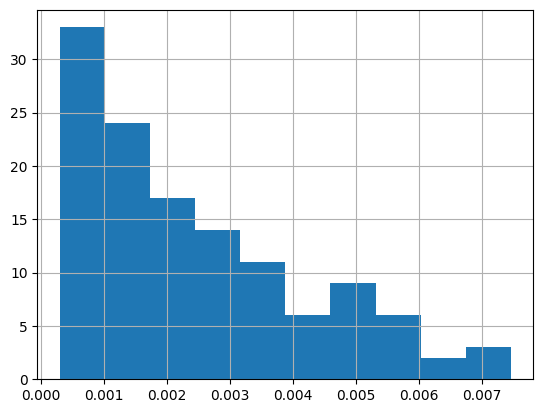

In [48]:
# Espacio para ejercicio

ejercicio.precio_de_calls.hist()

Por último, solo ver como avanza el precio de los calls.

<Axes: xlabel='Date'>

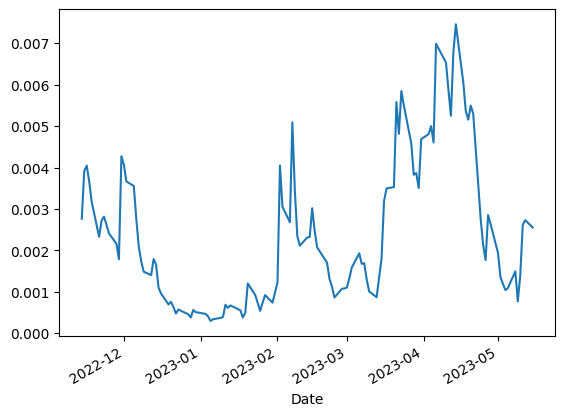

In [49]:
ejercicio.precio_de_calls.plot()

In [31]:
import matplotlib.pyplot as plt

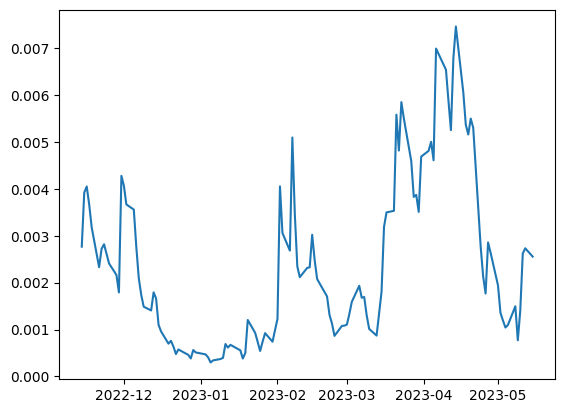

In [50]:
# Se puede graficar utilizando directamente la función del módulo "Matplotlib"
plt.plot(ejercicio.precio_de_calls)